# General

In [1]:

# imports

import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


In [2]:
# Folder paths
origin_folder = os.getcwd()
print(origin_folder)
mes_folder_1 = os.path.join(origin_folder,"kinetics_data","part 1")
mes_folder_2 = os.path.join(origin_folder,"kinetics_data","part 2")
mes_folder_3 = os.path.join(origin_folder,"kinetics_data","part 3")


c:\Users\yaniv\Yehonathan TAU\PhyChemLab


In [4]:
# Functions
def get_data(file_path, cut = [450,1200]):
    '''
    take raw data (.SSM/.ssm) and transform it to pd data frame 
    '''
    fix_file(file_path)
    df = pd.read_csv(file_path, delimiter = '\t', names = ['Wavelength', 'Intensity'], header = 0 )
    return df[(cut[0] < df['Wavelength']) & (df['Wavelength'] < cut[1])]

def culc_absorbance(I, I0,A = None):
    '''
    culculate absorbance dataframe from intensity
    '''
    A = pd.DataFrame()
    A['Absorbance'] = -np.log(I['Intensity']/I0['Intensity'])
    A['Wavelength'] = I['Wavelength']

    return A

def get_concentration(file_name):
    '''
    get concentration from file name
    '''
    return float(file_name.split('_')[0]) # file name is like 0.1_M.SSM


def culc_molar_absorption_coefficient(slope, error, l = 1):
    '''
    culculate molar absorption coefficient from absorbance and concentration
    '''
    return slope / l, error / l

def linear_func(x,a0,a1): # define the modle fucntion - linear
    return a1 * x + a0

def linear_fit(x,y):
    '''
    fit linear function
    '''
    popt, pcov = curve_fit(linear_func, x, y)
    return popt, np.sqrt(np.diag(pcov))


# function for part 3:

def get_episod(file_name):
    '''
    get episod from file name
    '''
    return int(file_name.split('-')[1].split('Ep')[0]) # file name is like sol1-1Ep.SSM

def get_sol_data(sol_num = None, I0 = None):
    '''
    get the absorbans spectra of the solution (numerd sol_num) in all the episods
    '''
    folder_name = 'sol' + str(sol_num)
    absorbance_all3 = pd.DataFrame()
    my_dict = {'Wavelength': np.array(I0['Wavelength'])}
    for file in os.listdir(folder_name):
        if file.endswith(".ssm"):
            I = get_data(os.path.join(folder_name, file))
            absorbance = culc_absorbance(I, I0)
            episod = get_episod(file)
            my_dict[str(episod)] = absorbance['Absorbance']
    
    return pd.DataFrame(my_dict)

def get_sol_data_wavelength(absorbance_all3, total_time, wavelength, epsilon):
    '''
    get the absorbans spectra of the solution (numerd sol_num) in all the episods
    '''
    episod_list = absorbance_all3.columns[1:].astype(int)
    avg_time_interval = total_time / max(episod_list)

    df = pd.DataFrame({'Episod': episod_list})
    df['time'] = avg_time_interval * episod_list
    df['Absorbance'] = absorbance_all3.loc[absorbance_all3['Wavelength'] == wavelength].values[0][1:]
    df['concentration'] = get_concentration_from_absorbance(df['Absorbance'],epsilon, l = 1)
    return df

def get_concentration_from_absorbance(A,epsilon,l = 1):
    return A / (epsilon * l)


def fix_file(file_path):
    '''
    fix the file to be read by pandas
    '''
    with open(file_path, 'r') as file:
        filedata = file.read()

    filedata = filedata.replace('  ', '\t')
    filedata = filedata.replace(' ', '')
    filedata = '\n'.join(filedata.split('\n')[2:])

    with open(file_path, 'w') as file:
        file.write(filedata)

def get_rate_of_reaction(concentration, time):
    '''
    get the rate of reaction from the concentration and time
    '''



# Part 1:  Beer-Lambert's Law Validation

Current Directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab\kinetics_data\part 1


c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, 

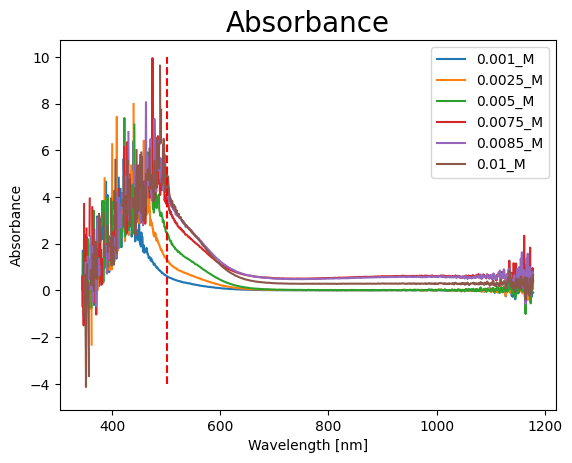

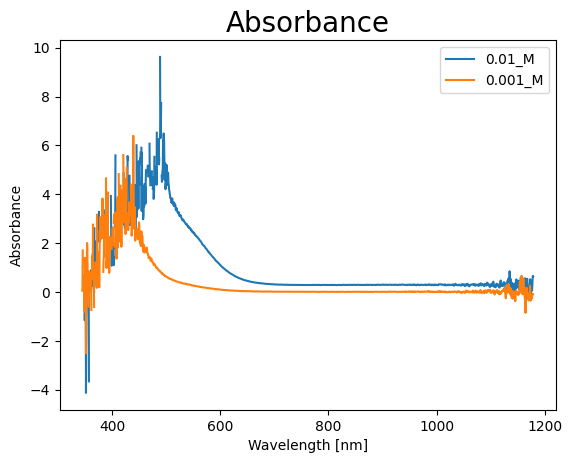

In [15]:
# Change directory to mes_folder_1 if not already there
if os.getcwd() != mes_folder_1:
    os.chdir(mes_folder_1)
print("Current Directory:", os.getcwd())

cut = [300,1200]
# define I0
dark = get_data(r"dark.SSM", cut = cut)
I0 = get_data(r"blank.SSM", cut = cut)
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

# get absobance data frame
Absorbabce_all = pd.DataFrame()
Absorbabce_all['Wavelength'] = I0['Wavelength']
for file in os.listdir('.'):
    if file.endswith(".SSM") and file != 'I0.SSM' and file != 'dark.SSM' and file != 'blank.SSM':
        data = get_data(file, cut = cut)
        data['Intensity'] = data['Intensity'] - dark['Intensity']
        # plt.plot(data['Wavelength'], data['Intensity'], label = file)
        C = get_concentration(file)
        Absorbabce_all[str(C) + '_M'] = culc_absorbance(data, I0)['Absorbance']

        plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all[str(C) + '_M'], label = str(C) + '_M')

plt.vlines(500.5, -4,10, color = 'r', linestyle = '--')
plt.legend()
plt.title('Absorbance', fontsize = 20)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Absorbance')
plt.show()
plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all['0.01_M'], label = '0.01_M')
plt.plot(Absorbabce_all['Wavelength'], Absorbabce_all['0.001_M'], label = '0.001_M')
plt.legend()
plt.title('Absorbance', fontsize = 20)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Absorbance')
plt.show()
# display(Absorbabce_all)

In [6]:
# change data frame to more readable format

# Create a dictionary to hold the data for each wavelength
data_dict = {'Concentration': [get_concentration(file) for file in os.listdir('.') if file.endswith(".SSM") and file != 'I0.SSM' and file != 'dark.SSM' and file != 'blank.SSM']}
for wavelength in Absorbabce_all['Wavelength']:
    data_dict[str(wavelength)] = Absorbabce_all[Absorbabce_all['Wavelength'] == wavelength].drop(columns='Wavelength').values[0]

# Use pd.concat to join all columns at once
Absorbabce_all2 = pd.concat([pd.DataFrame(data_dict)], axis=1)

# display(Absorbabce_all2)

$$
A = - \log \left(I/I_0\right)
$$

$$
A = \varepsilon c l
$$

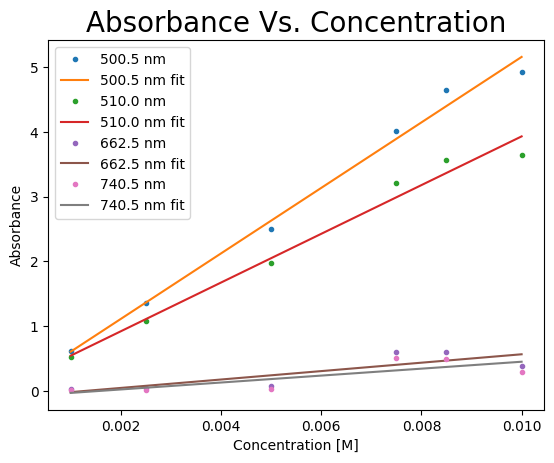

Molar Absorption Coefficients ε [M^-1 cm^-1]:


,wavelength [nm],molar_absorption,molar_absorption_err
0,500.5,506.070647,24.334107
1,510.0,376.452409,27.001475
2,662.5,64.991287,21.347257
3,740.5,53.551645,20.400773


In [7]:
# Plot the data and extract the molar absorption coefficient for each wavelength

wavelengths_list = [500.5,510.0,662.5, 740.5] # replace with the wavelengths you want to use

l = 1 # in cm - optic path length
if l is None:
    raise ValueError("Optic path length (l) must be defined.")

molar_absorption = {'wavelength [nm]': wavelengths_list, 'molar_absorption': [], 'molar_absorption_err': []}
for wavelength in wavelengths_list:
    # Fit a linear function to the data
    fit = linear_fit(Absorbabce_all2['Concentration'], Absorbabce_all2[str(wavelength)])
    plt.plot(Absorbabce_all2['Concentration'], Absorbabce_all2[str(wavelength)], '.', label=str(wavelength) + ' nm')
    plt.plot(Absorbabce_all2['Concentration'], linear_func(Absorbabce_all2['Concentration'], *fit[0]), label=str(wavelength) + ' nm fit')

    # Calculate molar absorption coefficient
    epsilon = culc_molar_absorption_coefficient(fit[0][1], fit[1][1], l) # in M^-1 cm^-1
    molar_absorption['molar_absorption'].append(epsilon[0])
    molar_absorption['molar_absorption_err'].append(epsilon[1]) 

plt.legend()
plt.xlabel('Concentration [M]')
plt.ylabel('Absorbance')
plt.title('Absorbance Vs. Concentration', fontsize=20)
plt.show()

molar_absorption_df = pd.DataFrame(molar_absorption)
print('Molar Absorption Coefficients ε [M^-1 cm^-1]:')
display(molar_absorption_df)

# Part 2: Determination of Optimal Acid:Acetone:Iodide Ratio


In [8]:
if os.getcwd() != mes_folder_2:
    os.chdir(mes_folder_2)
print("Current Directory:", os.getcwd())

# define I0
dark = get_data(r"dark.SSM")
I0 = get_data(r"blank.SSM")
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

# find c at wavelength
waveeps = molar_absorption_df[['wavelength [nm]','molar_absorption']].loc[0].values

sol_data = get_sol_data(1, I0)
# display(sol_data)
sold_data_wavelength = get_sol_data_wavelength(sol_data, 370, *waveeps)

# display(sold_data_wavelength)


Current Directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab\kinetics_data\part 2


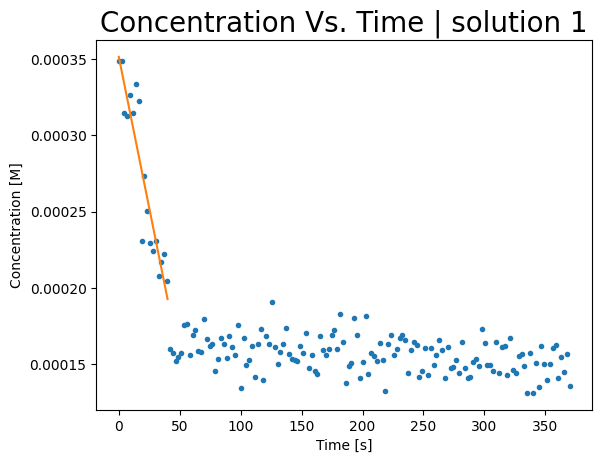

Rate of reaction [M/s]: 3.970e-06 ± 4.107e-07


In [9]:
# get rate of reaction
fit_interval = 40 # in seconds
df_fit = sold_data_wavelength[sold_data_wavelength['time'] < fit_interval]
fit = linear_fit(df_fit['time'], df_fit['concentration'])

# plot the Concentration Vs. time
if True:
    plt.plot(sold_data_wavelength['time'], sold_data_wavelength['concentration'], '.')
    t_show = np.linspace(0, fit_interval, 1000)
    plt.plot(t_show, linear_func(t_show, *fit[0]), label='fit')
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [M]')
    plt.title('Concentration Vs. Time | solution 1', fontsize=20)
    plt.show()

print('Rate of reaction [M/s]: {:.3e} ± {:.3e}'.format(-fit[0][1], fit[1][1]))

# Part 3: Finding the Reaction Order for Each Component

In [ ]:
# soltions initial concentrations table
xl_file_path = r"C:\Users\yaniv\OneDrive - mail.tau.ac.il\Chemical Kinetics.xlsx"
solutions_df = pd.read_excel(xl_file_path,index_col=0, sheet_name='Part 3 - solution')
solutions_df['total_time'] = [370,0,0,0,0,0]
solutions_df['fit_intervals'] = [40, 40, 40, 40, 40, 40]
display(solutions_df)

In [ ]:
if os.getcwd() != mes_folder_3:
    os.chdir(mes_folder_3)
print("Current Directory:", os.getcwd())

solutions = [1] # replace with the solutions you want to use

# define I0
dark = get_data(r"dark.SSM")
I0 = get_data(r"blank.SSM")
I0['Intensity'] = I0['Intensity'] - dark['Intensity']

rates = []
reate_errs = []

for sol_num in solutions:
    sol_data = get_sol_data(sol_num, I0)
    # display(sol_data)
    sold_data_wavelength = get_sol_data_wavelength(sol_data, solutions_df.loc[sol_num]['total_time'], *waveeps)

    # get rate of reaction
    fit_interval = solutions_df.loc[sol_num]['fit_intervals'] # in seconds
    df_fit = sold_data_wavelength[sold_data_wavelength['time'] < fit_interval]
    fit = linear_fit(df_fit['time'], df_fit['concentration'])

    # save the rate of reaction
    rates.append(-fit[0][1])
    reate_errs.append(fit[1][1])

    # plot the Concentration Vs. time
    if True:
        plt.plot(sold_data_wavelength['time'], sold_data_wavelength['concentration'], '.', label='solution ' + str(sol_num))
        t_show = np.linspace(0, fit_interval, 1000)
        plt.plot(t_show, linear_func(t_show, *fit[0]))
        plt.xlabel('Time [s]')
        plt.ylabel('Concentration [M]')
        plt.title('Concentration Vs. Time', fontsize=20)
        plt.legend()
plt.show()
    
rates_DF = pd.DataFrame({'solution': solutions, 'rate [M/s]': rates, 'rate_err [M/s]': reate_errs})
rates_DF.index = rates_DF['solution']
display(rates_DF)


## Order for I2 (q)

$$
\log(rate) = q \cdot \log ([I_2]_{t=0}) + Const.
$$


In [ ]:
I2_solutoins = [1] # replace with the solutions you want to use

x = np.log10(solutions_df.loc[I2_solutoins]['I2'])
y = np.log10(rates_DF.loc[I2_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel('log([I2])')
plt.ylabel('log(rate)')
plt.title('Order of reaction with respect to I2 (q)', fontsize=20)
plt.show()

print('The order of the reaction with respect to I2 is q = {:.3f} ± {:.3f}'.format(fit[0][1], fit[1][1]))

## Order for Acetone (p)

$$
\log(rate) = p \cdot \log ([Ac]_{t=0}) + Const.
$$


In [ ]:
Ac_solutoins = [1] # replace with the solutions you want to use

x = np.log10(solutions_df.loc[Ac_solutoins]['acetone'])
y = np.log10(rates_DF.loc[Ac_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel('log([Ac])')
plt.ylabel('log(rate)')
plt.title('Order of reaction with respect to Acetone (p)', fontsize=20)
plt.show()

print('The order of the reaction with respect to Acetone is q = {:.3f} ± {:.3f}'.format(fit[0][1], fit[1][1]))

## Order for Acid (r)

$$
\log(rate) = r \cdot \log ([H^+]_{t=0}) + Const.
$$


In [ ]:
H_solutoins = [1] # replace with the solutions you want to use

x = np.log10(solutions_df.loc[H_solutoins]['acetone'])
y = np.log10(rates_DF.loc[H_solutoins]['rate [M/s]'])

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel(r'log([{H^+}])')
plt.ylabel('log(rate)')
plt.title(r'Order of reaction with respect to {H^+} (r)', fontsize=20)
plt.show()

print('The order of the reaction with respect to H+ is r = {:.3f} ± {:.3f}'.format(fit[0][1], fit[1][1]))

# Part 4 - rate constant for the reaction

In [ ]:
p, q, r = 1, 0, 1

y = rates_DF['rate [M/s]']
x = solutions_df['I2']**q * solutions_df['acetone']**p * solutions_df['H+']**r

fit = linear_fit(x, y)

plt.plot(x, y, '.')
plt.plot(x, linear_func(x, *fit[0]))
plt.xlabel(r'[{I2}]^q * [{Ac}]^p * [{H^+}]^r')
plt.ylabel('rate')
plt.title('Rate constatnt', fontsize=20)
plt.show()

print('The rate constant is k = {:.3e} ± {:.3e}'.format(fit[0][1], fit[1][1]))